# Lab 2 Exploration: Color Images

In this notebook, we will learn how to use the racecar camera to identify objects based on their color and extract the center and area of these objects.

Throughout this notebook, **<font style="color:red">text in bold red</font>** indicates a change you must make to the following code block before running it.

## Table of Contents
1. [Getting Started](#GettingStarted)
1. [Taking Photos](#TakingPhotos)
1. [Color Formats](#ColorFormats)
1. [Masks](#Masks)
1. [Finding Contours](#FindingContours)
1. [Contour Center](#ContourCenter)
1. [Contour Area](#ContourArea)
1. [Processing Numeric Values](#ProcessingNumericValues)
1. [Proportional Control](#ProportionalControl)

<a id="GettingStarted"></a>
## 1. Getting Started

**<font style="color:red">If you are running the car in RacecarSim, set `isSimulation` to `True`</font>**. Leave `isSimulation` `False` if you are using a physical car.

In [1]:
# TODO: Update isSimulation if necessary
isSimulation = True

Next, we will import the necessary libraries for this notebook, including Python libraries (`cv`, `numpy`, etc.) and the Racecar library (`racecar_core`).

In [2]:
# Import Python libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from nptyping import NDArray
from typing import Any, Tuple, List, Optional

# Import Racecar library
import sys
sys.path.append("../../library")
import racecar_core

The following functions will help us throughout this notebook.

In [3]:
def show_image(image: NDArray) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    """
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

    
def draw_contour(
    image: NDArray,
    contour: NDArray,
    color: Tuple[int, int, int] = (0, 255, 0)
) -> None:
    """
    Draws a contour on the provided image.

    Args:
        image: The image on which to draw the contour.
        contour: The contour to draw on the image.
        color: The color to draw the contour in BGR format.
    """
    cv.drawContours(image_copy, [contour], 0, color, 3)

    
def draw_circle(
    color_image: NDArray[(Any, Any, 3), np.uint8],
    center: Tuple[int, int],
    color: Tuple[int, int, int] = (0, 255, 255),
    radius: int = 6,
) -> None:
    """
    Draws a circle on the provided image.

    Args:
        color_image: The color image on which to draw the contour.
        center: The pixel (row, column) of the center of the image.
        color: The color to draw the circle in BGR format.
        radius: The radius of the circle in pixels.
    """
    # cv.circle expects the center in (column, row) format
    cv.circle(color_image, (center[1], center[0]), radius, color, -1)

    
def show_color_bgr(blue: int, green: int, red: int) -> None:
    """
    Displays a color specified in the BGR format.
    """
    rectangle = plt.Rectangle((0,0), 50, 50, fc=(red/255, green/255, blue/255))
    plt.gca().add_patch(rectangle)
    plt.show()

    
def show_color_hsv(hue: int, saturation: int, value: int) -> None:
    """
    Displays a color specified in the HSV format
    """
    # Convert from hsv to bgr
    hsv = np.array([[[hue, saturation, value]]], np.uint8)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    
    show_color_bgr(bgr[0][0][0], bgr[0][0][1], bgr[0][0][2])

Finally, we will create a racecar object.  If this step fails, make sure that `isSimulation` has the correct value.

In [4]:
# Create Racecar
rc = racecar_core.create_racecar(isSimulation)

>> Racecar created with the following options:
    Simulation (-s): [True]
    Headless (-h): [False]
    Initialize with display (-d): [False]


<a id="TakingPhotos"></a>
## 2. Taking Photos
In Jupyter Notebook, we can take a photo with the car's camera using `rc.camera.get_color_image_async()`.  Outside of Jupyter Notebook, we must use `rc.camera.get_color_image()` instead.

Let's see what the car is currently looking at.

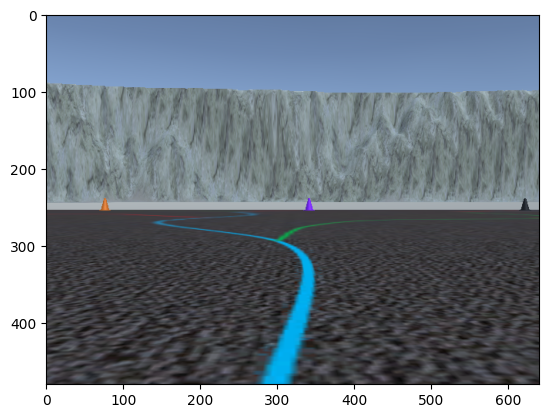

In [5]:
# Take and display a photo
image = rc.camera.get_color_image_async()
show_image(image)

Color images are stored as three dimensional numpy arrays:

* **0th dimension**: pixel rows, indexed from top to bottom.
* **1st dimension**: pixel columns, indexed from left to right.
* **2nd dimension**: pixel color values, ordered blue, green, red, each ranging from 0 (none of that color) to 255 (maximum amount of that color). 

Let's look at the color values of the middle pixel of our image.

blue: 128
green: 125
red: 114


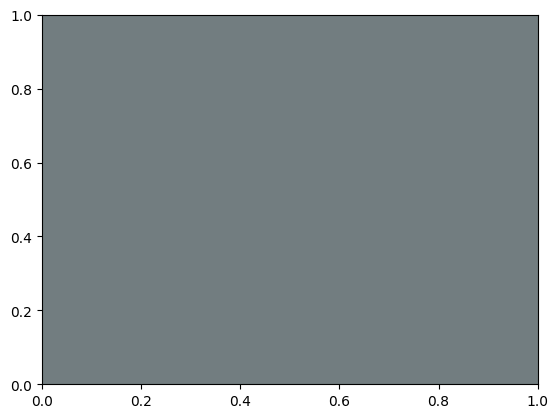

In [6]:
# Calculate center row and column
row = rc.camera.get_height() // 2
col = rc.camera.get_width() // 2

# Extract and print blue, green, and red values
blue = image[row][col][0]
green = image[row][col][1]
red = image[row][col][2]

print("blue:", blue)
print("green:", green)
print("red:", red)

# Display this color
show_color_bgr(blue, green, red)

**<span style="color:red">Update `row` and `col` in the following code block to show the pixel that is is 2/3 from the top, 1/4 from the right.</span>**

blue: 44
green: 46
red: 49


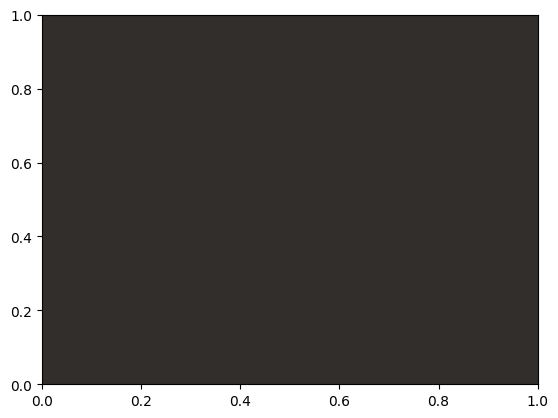

In [7]:
# TODO: Calculate the desired row and column 
row = 2 * rc.camera.get_height() // 3
col = rc.camera.get_width() // 4

# Extract and print blue, green, and red values
blue = image[row][col][0]
green = image[row][col][1]
red = image[row][col][2]

print("blue:", blue)
print("green:", green)
print("red:", red)

# Display this color
show_color_bgr(blue, green, red)

<a id="ColorFormats"></a>
## 3. Color Formats
By default, the images captured by the camera are stored in the blue-green-red (BGR) format.  However, when recognizing objects based on their color, it is far easier to use the hue-saturation-value (HSV) format, in which each channel corresponds to the following:

* **Hue** (0 to 180): The color as it appears on a color wheel, ordered as red-orange-yellow-green-blue-purple-red
* **Saturation** (0 to 255): The amount of white added to the color.  0 is pure white, and 255 is the pure color without any white added.
* **Value** (0 to 255): The amount of black added to the color.  0 is pure black, and 255 is the pure color without any black added.

While saturation and value vary with lighting, hue will remain mostly the same regardless of lighting.  By focusing on the hue of the object we are attempting to detect, we can find it even in different lighting environments.

We can use the following widgets to experiment with different color values in the BGR and HSV formats.  **<font style="color:red">For both formats, find the values which produce the following colors: orange, pink, dark green, yellow, and gray.</font>**

In [8]:
# BGR color
widgets.interact(show_color_bgr,
                 blue=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 green=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 red=widgets.IntSlider(0, 0, 255, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='blue', max=255), IntSlider(valu…

In [9]:
# HSV color
widgets.interact(show_color_hsv,
                 hue=widgets.IntSlider(0, 0, 180, continuous_update=False),
                 saturation=widgets.IntSlider(255, 0, 255, continuous_update=False),
                 value=widgets.IntSlider(255, 0, 255, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='hue', max=180), IntSlider(value…

<a id="Masks"></a>
## 4. Masks
Lets work on identifying an object in the car's field of view based on its color.  Specifically, we will isolate the portions of an image which fall within a certain color range by defining upper and lower HSV bounds.  We will use that to create a *mask* - a special type of image which is white in areas to include and black in areas not to include.

**<font style="color:red">Finish writing the function `get_mask` below, which takes an image and returns a mask of the areas between hsv_lower and hsv_upper.</font>**  You will likely wish to use the following OpenCV functions:

* [`cvtColor`](https://docs.opencv.org/4.2.0/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab): Converts an image from one color format to another, such as from BGR to HSV.
* [`inRange`](https://docs.opencv.org/4.2.0/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981): Creates a mask from an image based on a lower and upper color bound.

In [10]:

def get_mask(
    image: NDArray[(Any, Any, 3), np.uint8],
    hsv_lower: Tuple[int, int, int],
    hsv_upper: Tuple[int, int, int]
) -> NDArray[Any, Any]:
    """   
    Returns a mask containing all of the areas of image which were between hsv_lower and hsv_upper.
    
    Args:
        image: The image (stored in BGR) from which to create a mask.
        hsv_lower: The lower bound of HSV values to include in the mask.
        hsv_upper: The upper bound of HSV values to include in the mask.
    """
    # Convert hsv_lower and hsv_upper to numpy arrays so they can be used by OpenCV
    hsv_lower = np.array(hsv_lower)
    hsv_upper = np.array(hsv_upper)
    
    # TODO: Use the cv.cvtColor function to switch our BGR colors to HSV colors
    img = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    # TODO: Use the cv.inRange function to highlight areas in the correct range
    mask = cv.inRange(img, hsv_lower, hsv_upper)
    
    return mask

Let's use `get_mask` to isolate the orange cone(s) in an image.  Place one or more orange cones in the car's line of sight and take a picture with the following block. (If you do not have an orange cone, you can use any object with a distinct color).

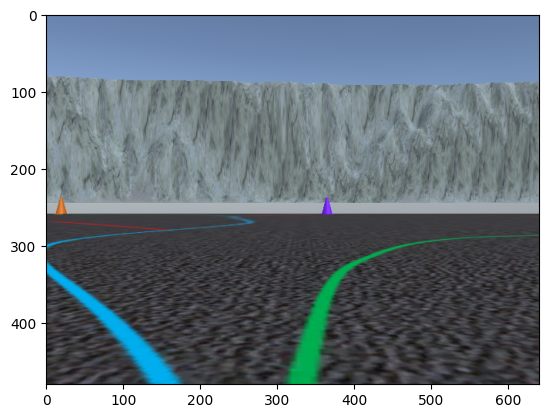

In [44]:
image = rc.camera.get_color_image_async()

show_image(image)

Next, we will use the `get_mask` function to create a mask containing just the cone(s).  At the moment, `hsv_lower` and `hsv_upper` include all possible HSV values, so the mask will contain the entire image.  **<font style="color:red">Tune the values of `hsv_lower` and `hsv_upper` until the mask only includes the cone(s).</font>**

**Hints:**

* Use the HSV color widget from [Color Formats](#ColorFormats) to visualize HSV colors.
* Copy the image into an image editing software (gimp, paint, etc.) and use the eyedropper (color picker) tool to show the HSV values of the pixels in the cone.
* Saturation and value vary a lot with lighting, but hue will remain mostly constant for a given object. Try using a wide range for value and saturation but a tight range for hue.

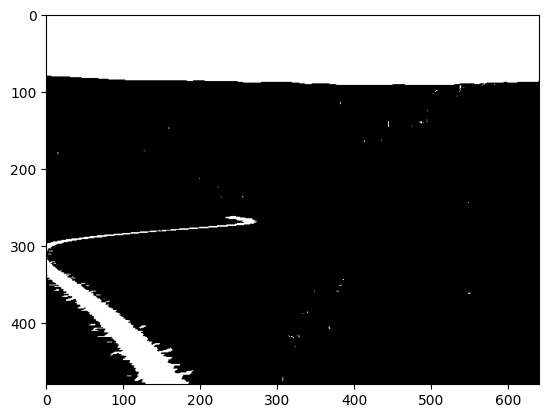

In [45]:
hsv_lower = (90, 50, 50)
hsv_upper = (115, 255, 255)

mask = get_mask(image, hsv_lower, hsv_upper)

show_image(mask)

We can use this mask as a filter for our original image to only keep portions that were between `hsv_lower` and `hsv_upper`.

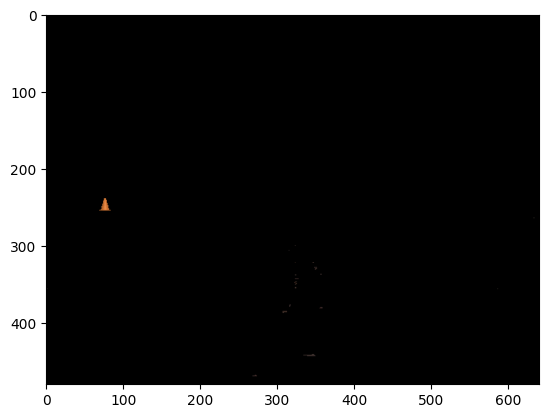

In [13]:
masked_image = cv.bitwise_and(image, image, mask=mask)
show_image(masked_image)

<a id="FindingContours"></a>
## 5. Finding Contours

Now that we have a mask, we can create outlines called _contours_ around each object in the mask.  We will use these outlines to identify the largest object and calculates its size and position.

First, we will use the OpenCV function [`findContours`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) to create a list of contours around each distinct object in the mask.

In [14]:
def find_contours(mask: NDArray) -> List[NDArray]:
    """
    Returns a list of contours around all objects in a mask.
    """
    return cv.findContours(mask, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[0]

`find_contours` will return a list containing multiple contours if there are multiple distinct objects which fall between `hsv_lower` and `hsv_upper`.  This might occur if there are multiple cones in the image or if there are other objects that have a similar color to the cone(s).

Let's write a helper function to identify the largest contour, which we will assume is the closest cone.  This helper function should also ignore contours below a minimum size (such as `30 pixels`), since anything below this size is likely too small to be a cone.

**<font style="color:red">Finish writing `get_largest_contour` so that it returns the largest contour larger than `min_area`, or `None` if no such contour exists.</font>**  You will likely wish to use the OpenCV [`contourArea`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) function to find the number of pixels in a contour.

In [15]:
def get_largest_contour(contours: List[NDArray], min_area: int = 30) -> Optional[NDArray]:
    """
    Finds the largest contour with size greater than min_area.

    Args:
        contours: A list of contours found in an image.
        min_area: The smallest contour to consider (in number of pixels)

    Returns:
        The largest contour from the list, or None if no contour was larger than min_area.
    """
    if len(contours) == 0:
        # TODO: What should we return if the list of contours is empty?
        return None
    
    # TODO: Return the largest contour, but return None if no contour is larger than min_area
    max = 0
    
    for i in contours:
        if cv.contourArea(i) > max:
            max = cv.contourArea(i) 
            contour = i
    if max <= min_area:
        return None
    return contour


Let's try it out.  The following code block uses `find_contours` and `get_largest_contour` to find the largest contour and draw it on the image.  We should now see a green outline surrounding the closest cone in our image.

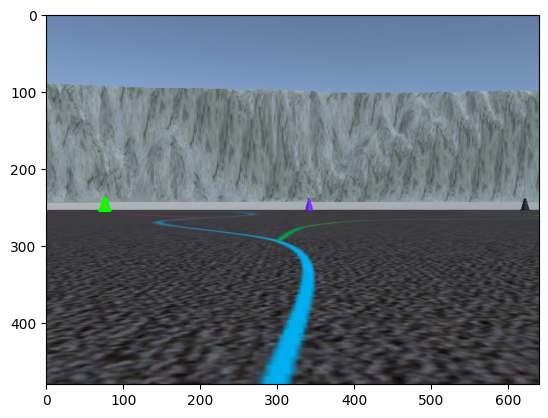

In [16]:
# Find the largest contour
contours = find_contours(mask)
largest_contour = get_largest_contour(contours)

# Draw it on the image
image_copy = np.copy(image)
draw_contour(image_copy, largest_contour)
show_image(image_copy)

<a id="ContourCenter"></a>
## 6. Contour Center

One advantage of contours is that we can use them to easily calculate the center of an object.  Specifically, we will use the contour's [_Moments_](https://en.wikipedia.org/wiki/Image_moment), which are weighted averages of the pixels in the contour.  We can calculate the moment $M_{ij}$ with the following formula:

```
def moment(i, j):
    sum = 0
    for pixel in contour:
        sum += pixel.x_position ** i + pixel.y_position ** j
    return sum
```

To calculate contour center, we will use the following moments:

* $M_{00}$: The number of pixels in the contour.
* $M_{10}$: The sum of how far to the right each pixel in the contour is.
* $M_{01}$: The sum of how far down each pixel in the contour is.

Using the [center of mass equation](https://en.wikipedia.org/wiki/Center_of_mass), $\frac{M['m10']}{M['m00']}$ gives us the average horizontal position (column) of the contour, and $\frac{M['m01']}{M['m00']}$ gives us the average vertical position (row).

In [17]:
def get_contour_center(contour: NDArray) -> Optional[Tuple[int, int]]:
    """
    Finds the center of a contour from an image.

    Args:
        contour: The contour of which to find the center.

    Returns:
        The (row, column) of the pixel at the center of the contour, or None if the contour is empty.
    """
    # Ask OpenCV to calculate the contour's moments
    M = cv.moments(contour)

    # Check that the contour is not empty
    if M["m00"] <= 0:
        return None

    # Compute the center of mass of the contour
    center_row = round(M["m01"] / M["m00"])
    center_column = round(M["m10"] / M["m00"])
    
    return (center_row, center_column)

To see if this worked, we will draw a dot at this calculated center point. We should now see a yellow dot at the center of the cone.

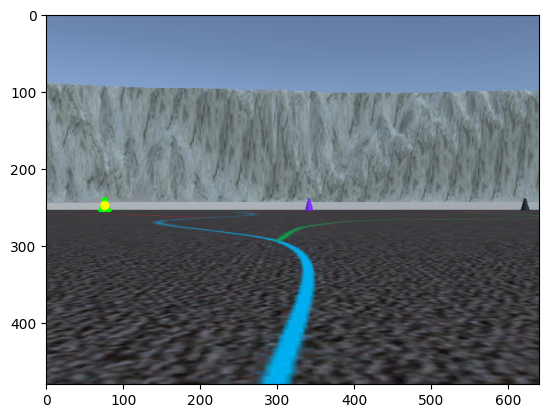

In [18]:
center = get_contour_center(largest_contour)

# Draw a circle at the contour center
draw_circle(image_copy, center)
show_image(image_copy)

<a id="ContourArea"></a>
## 7. Contour Area

When writing `get_largest_contour`, you likely used the OpenCV [`contourArea`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) function.  Contour area is also helpful for calculating how far an object is from the camera, since the closer an object is, the more pixels it will take up on the screen.

In this section, we will measure the area of the cone at different distances from the car. Using previous examples from this notebook, **<font style="color:red">update the following code block to take a photo, find the largest contour, print the contour area, and display the image with the contour.</font>**

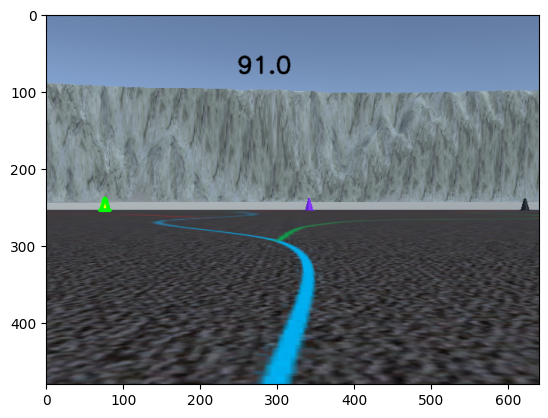

In [19]:
# TODO: Take a photo
image = rc.camera.get_color_image_async()
image_copy = np.copy(image)
mask = get_mask(image, hsv_lower, hsv_upper)

# TODO: Find the largest contour
# Find the largest contour
contours = find_contours(mask)

# TODO: Calculate and print the largest contour's area
largest_contour = get_largest_contour(contours)


# TODO: Display the image with the contour drawn on top
center = get_contour_center(largest_contour)
# Draw a circle at the contour center
draw_circle(image_copy, center)
draw_contour(image_copy, largest_contour)
image_copy = cv.putText(image_copy,str(cv.contourArea(largest_contour)),center,cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2,cv.LINE_AA)
show_image(image_copy)


**<font style="color:red">Measure the cone contour area when the cone is the following distances away from the car: 40 cm, 80 cm, 120 cm, 160 cm, 200 cm.  Update the entries in `data` with your results.</font>**

In [20]:
# Datapoints in the format (cone distance from car in cm, number of pixels in contour)
# TODO: Fill is contour area (currently 0)
data = [
    (40, 17770),
    (80, 4940),
    (120, 2253),
    (160, 1265),
    (200, 795),
]

Let's plot this data to see the relationship between distance and cone area.  **How would you describe this relationship?**

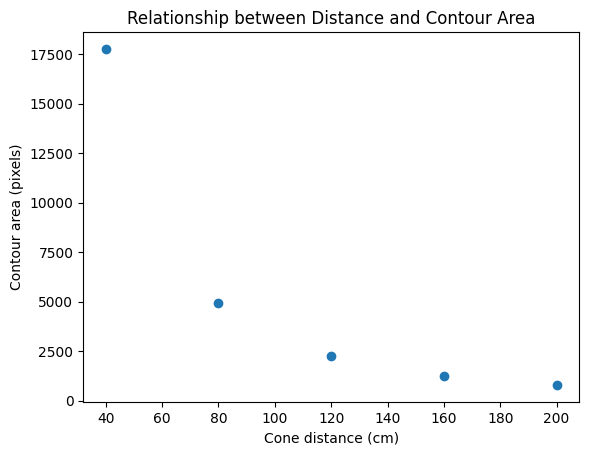

In [21]:
# Plot data in a scatter plot 
data_t = np.transpose(data)
plt.scatter(data_t[0], data_t[1])
plt.title("Relationship between Distance and Contour Area")
plt.xlabel("Cone distance (cm)")
plt.ylabel("Contour area (pixels)")
plt.show()

<a id="ProcessingNumericValues"></a>
## 8. Processing Numeric Values

At a high level, many robotics tasks can be summarized as follows:

1. Receive raw inputs from one or more sensors (images, IMU data, LIDAR scans, etc.).
2. Convert these raw inputs into numeric values (contour center, contour area, center distance, current velocity, etc.).
3. Use these numeric values to calculate output values (speed, angle, etc.).
4. Send these output values to controllers (motors, etc.).

In the previous sections, we saw two examples of step 2 when we turned a color image (a raw input) into the a center point and a contour area (numeric values).  In this section, we will build up two useful tools for step 3: turning these numeric values into output values.

### Clamp
Frequently, an output value must fall within a certain range.  For example, the speed and angle sent to `rc.drive.set_speed_angle()` must be in the range $[-1, 1]$.  *Clamping* refers to the process of forcing a value into a particular range.  If the value is less than the minimum, it receives the minimum value, and if the value is greater than the maximum, it receives the maximum value.

For example, clamp should return the following outputs:

* `clamp(3, 0, 10) = 3`: $3$ is between $0$ and $10$, so no change is necessary.
* `clamp(-2, 0, 10) = 0`: $-2$ is less than $0$, so we saturate it at the minimum value.
* `clamp(11, 0, 10) = 10`: $11$ is greater than $10$, so we saturate it at the maximum value.

**<font style="color:red">Implement this behavior in the `clamp` function below.</font>**

In [22]:
def clamp(value: float, vmin: float, vmax: float) -> float:
    """
    Clamps a value between a minimum and maximum value.

    Args:
        value: The input to clamp.
        vmin: The minimum allowed value.
        vmax: The maximum allowed value.

    Returns:
        The value saturated between vmin and vmax.
    """
    # TODO: Make sure that value is between min and max
    if value < vmin:
        value = vmin
    elif value > vmax:
        value = vmax
    return value
    

Let's test out our `clamp` function.

In [23]:
# Testing clamp
assert clamp(3, 0, 10) == 3
assert clamp(-2, 0, 10) == 0
assert clamp(11, 0, 10) == 10

We can use the following widget to experiment with different inputs.

In [24]:
widgets.interact(clamp,
                 value=widgets.FloatSlider(0, min=-2, max=2, step=0.1),
                 vmin=widgets.fixed(-1),
                 vmax=widgets.fixed(1))

interactive(children=(FloatSlider(value=0.0, description='value', max=2.0, min=-2.0), Output()), _dom_classes=…

<function __main__.clamp(value: float, vmin: float, vmax: float) -> float>

### Remap Range

We often wish to take action based on where an input value falls within a given range.  For example, we may set the car's angle based on the x-coordinate of a contour center, or set the car's speed based on the center distance of a depth image.  One approach is to *remap* the input value from a range of possible input values to a range of possible output values.

For example, suppose we are remapping the range $[0, 1]$ to $[-1, 1]$. The value $0$ (the old min) becomes $-1$ (the new min), $0.5$ (the old midpoint) becomes $0$ (the new midpoint), and the value $1$ (the old max) becomes $1$ (the new max).

The ranges do not necessarily need to be "in order".  For example, suppose that we want small numbers to become large and vice versa.  We can achieve this by flipping the new range, such as remapping $[0, 10]$ to $[10, 0]$.  For example, $2$ will become $8$, $0$ will become $10$, and $6$ will become $4$.  We can even use values outside of this initial range: $20$ will become $-10$, and $-2$ will become $12$. 

**<font style="color:red">In `remap_range`, write code to remap `val` from an old range to a new range.</font>**

In [25]:
def remap_range(
    val: float,
    old_min: float,
    old_max: float,
    new_min: float,
    new_max: float,
) -> float:
    """
    Remaps a value from one range to another range.

    Args:
        val: A number form the old range to be rescaled.
        old_min: The inclusive 'lower' bound of the old range.
        old_max: The inclusive 'upper' bound of the old range.
        new_min: The inclusive 'lower' bound of the new range.
        new_max: The inclusive 'upper' bound of the new range.

    Note:
        min need not be less than max; flipping the direction will cause the sign of
        the mapping to flip.  val does not have to be between old_min and old_max.
    """
    # TODO: remap val to the new range
    a = (val - old_min) / (old_max - old_min)
    return a * (new_max - new_min) + new_min


Let's test our `remap range` function.

In [26]:
# Testing remap_range
assert remap_range(5, 0, 10, 0, 50) == 25
assert remap_range(5, 0, 20, 1000, 900) == 975
assert remap_range(2, 0, 1, -10, 10) == 30
print(remap_range(1245,0,1980,-1,1 ))

0.25757575757575757


We can use the following widget to experiment with different inputs.  **Find three different input combinations which yield the output $2.0$**.

In [27]:
widgets.interact(remap_range,
                 val=widgets.FloatSlider(0, min=-10, max=10, step=0.1),
                 old_min=widgets.FloatSlider(0, min=-10, max=10, step=0.1),
                 old_max=widgets.FloatSlider(5, min=-10, max=10, step=0.1),
                 new_min=widgets.FloatSlider(-1, min=-10, max=10, step=0.1),
                 new_max=widgets.FloatSlider(1, min=-10, max=10, step=0.1))

interactive(children=(FloatSlider(value=0.0, description='val', max=10.0, min=-10.0), FloatSlider(value=0.0, d…

<function __main__.remap_range(val: float, old_min: float, old_max: float, new_min: float, new_max: float) -> float>

<a id="ProportionalControl"></a>
## 9. Proportional Control

A frequent goal in robotics is to maintain a desired state.  For example, we may wish for the car to stay 30 cm away from a cone or maintain a speed of 1.0 m/s.  When the current state differs from the desired state, we use controllers on the car (such as throttle or steering) to move toward the desired state.  

One of the simplest ways to maintain steady state is [proportional control](https://en.wikipedia.org/wiki/Proportional_control).  This strategy applies a change that is *proportional* to the difference between the current value and the desired value.  For example, suppose that we wish to maintain a room at 20.0 degrees Celsius. For every degree the actual temperature differs from this desired value, we will apply 100 units of heating/cooling.  That is:
* If the current temperature is $20.0$ degrees, we are at the desired temperature so apply $0$ units of heating.
* If the current temperature is $19.7$ degrees, we apply $30$ units of heating
* If the current temperature is $21.7$ degrees, we apply $-170$ units of heating.

We can use `remap_range` to perform proportional control calculations by providing the following inputs:
* `val`: The input variable (ex: current temperature)
* `old_min`: One potential value for the input variable (ex: desired temperature)
* `old_max`: Another potential value for the input variable (ex: 1 degree less than the desired temperature)
* `new_min`: The desired output when the input is `old_min` (ex: no heating/cooling)
* `new_max`: The desired output when the input is `old_max` (ex: 100 units of heating)

Notice that `min` and `max` are not boundaries and do not need to be in order.  They are simply two reference points to characterize the linear relationship.

**<font style="color:red">Experiment with different values of `current_temp`.</font>**

In [28]:
DESIRED_TEMP = 20
current_temp = 1.7 # TODO: experiment with different values 

# Use remap_range to calculate the units of heating to apply
heating = remap_range(current_temp, DESIRED_TEMP, DESIRED_TEMP - 1, 0, 100)
print(f"{heating:.1f} units of heating")

1830.0 units of heating


If our output must fall within a certain range, we can use `clamp` to enforce this range.  For example, suppose that our thermostat can apply a maximum of 500 units of heating or cooling.  The following code block uses `clamp` to enforce this restriction.

**<font style="color:red">See what happens when `current_temp` is below 15 degrees or above 25 degrees.</font>**

In [29]:
clamped_heating = clamp(heating, -500, 500)
print(f"{clamped_heating:.1f} units of heating (after clamping)")

500.0 units of heating (after clamping)


For our final challenge, we will use proportional control to determine the front wheel angle based on the position of a cone in the color image.  Specifically, we will steer the car towards the cone with the following steps:
1. Take a color photo.
2. Mask the image based on color and identify the largest contour, which we assume is the cone.
3. Find the center of this contour.
4. Print the color image with the contour and center drawn on top.
5. Convert the column of the center to an angle using proportional control. That is, the car should turn to the left proportional to how far the cone is to the left, or turn to the right proportional to how far the cone is to the right.

**<font style="color:red">Perform these steps in the following block of code to calculate an angle.</font>**

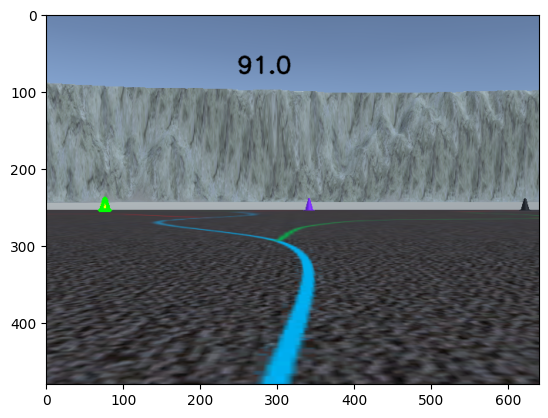

76
-0.7625
-0.7625


In [30]:
# Take a color photo

image = rc.camera.get_color_image_async()
image_copy = np.copy(image)
mask = get_mask(image, hsv_lower, hsv_upper)

# Find the largest contour
contours = find_contours(mask)

largest_contour = get_largest_contour(contours)


center = get_contour_center(largest_contour)
# Draw a circle at the contour center
draw_circle(image_copy, center)
draw_contour(image_copy, largest_contour)
image_copy = cv.putText(image_copy,str(cv.contourArea(largest_contour)),center,cv.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2,cv.LINE_AA)
show_image(image_copy)

# TODO: Display the image with the contour and center drawn on top
print(center[1])
pos = remap_range(center[1], 0, rc.camera.get_width(), -1, 1)
print(pos)
angle= clamp(pos, -1, 1)
print(angle)
# TODO: Use the contour center to calculate and print an angle in the range [-1, 1]


You are now ready to begin using the color camera to follow lines in `lab2a.py`. Good luck, and don't be afraid to ask questions!

In [31]:
def pid_control(
    p_gain,
    i_gain,
    d_gain,
    target_val,
    current_val,
    accumulated_error,
    last_error,
    dt
):

    error = target_val - current_val
    #change dt with time of car
    # Update the accumulated error
    accumulated_error += error * dt


    delta_error = (error - last_error) / dt

    p_term = p_gain * error
    i_term = i_gain * accumulated_error
    d_term = d_gain * delta_error

    return p_term + i_term + d_term, accumulated_error, error

def clamp(value: float, min_value: float, max_value: float) -> float:

    return max(min(value, max_value), min_value)

def test_pid_control():
    # Initial values
    p_gain = 0.1
    i_gain = 0.01
    d_gain = 0.01
    target_val = 5
    current_val = 0.0
    accumulated_error = 0.0
    last_error = 0.0
    dt = 1.0

    # Simulate a control loop for 100 seconds
    for t in range(100):

        output, accumulated_error, last_error = pid_control(
            p_gain, i_gain, d_gain, target_val, current_val, accumulated_error, last_error, dt
        )


        output = clamp(output, -1.0, 1.0)

        
        print(f"At time {t}, control output is {output}")

        current_val += output * dt

# Run the test
#CHRIS APPROVED
test_pid_control()




At time 0, control output is 0.6000000000000001
At time 1, control output is 0.528
At time 2, control output is 0.51464
At time 3, control output is 0.49688319999999997
At time 4, control output is 0.475977216
At time 5, control output is 0.45243355007999997
At time 6, control output is 0.4267462920704
At time 7, control output is 0.399381732861952
At time 8, control output is 0.37077658525771773
At time 9, control output is 0.3413365924452875
At time 10, control output is 0.3114355814417296
At time 11, control output is 0.28141492590602124
At time 12, control output is 0.2515833831101452
At time 13, control output is 0.22221726963535682
At time 14, control output is 0.1935609405184829
At time 15, control output is 0.16582753706453235
At time 16, control output is 0.13919996932870235
At time 17, control output is 0.11383210031598713
At time 18, control output is 0.08985010021415239
At time 19, control output is 0.06735394043125076
At time 20, control output is 0.04641899881913752
At ti

In [32]:
def test_pid_control():
    # Initial values
    p_gain = 0.1
    i_gain = 0.01
    d_gain = 0.01
    target_val = 10.0
    current_val = 0.0
    accumulated_error = 0.0
    last_error = 0.0
    dt = 1.0

    # Simulate a control loop for 100 seconds
    for t in range(100):
        # Call the PID controller
        output, accumulated_error, last_error = pid_control(
            p_gain, i_gain, d_gain, target_val, current_val, accumulated_error, last_error, dt
        )

        # In a real control system, you would use the output to control your system.
        # Here, we'll just print it out.
        print(f"At time {t}, control output is {output}")

        # For this test, we'll simulate that our system is slowly moving towards the target value.
        current_val += output * dt


# Run the test
test_pid_control()


At time 0, control output is 1.2000000000000002
At time 1, control output is 1.056
At time 2, control output is 1.02928
At time 3, control output is 0.9937663999999999
At time 4, control output is 0.951954432
At time 5, control output is 0.9048671001599999
At time 6, control output is 0.8534925841408
At time 7, control output is 0.798763465723904
At time 8, control output is 0.7415531705154355
At time 9, control output is 0.682673184890575
At time 10, control output is 0.6228711628834592
At time 11, control output is 0.5628298518120425
At time 12, control output is 0.5031667662202904
At time 13, control output is 0.44443453927071364
At time 14, control output is 0.3871218810369658
At time 15, control output is 0.3316550741290647
At time 16, control output is 0.2783999386574047
At time 17, control output is 0.22766420063197426
At time 18, control output is 0.17970020042830478
At time 19, control output is 0.13470788086250152
At time 20, control output is 0.09283799763827504
At time 21, 